In [1]:
import torch
import torch.nn.functional as F
import importlib
import matplotlib.pyplot as plt
import random
mm = importlib.import_module("makemore-1")

In [2]:
mm.CHARS

'.abcdefghijklmnopqrstuvwxyz'

In [3]:
words = mm.load_words_from_file('names.txt')

# what are we trying to do

add more context in training data. we don't want input-output pairs to just be $(c_k, c_{k+1})$, but rather $((c_{k-B+1}, \ldots, c_k), c_{k+1})$ for context length $B$.

From our set of words, build up a training set of character sequences $(c_{k-B+1}, \ldots, c_{k-1}) \mapsto c_k$.

In [35]:
def make_dataset_split(words, B):
  xs = []
  ys = []
  start_idx = mm.CHAR_INDICES['.']
  
  for word in words:
    # initial context_array = [0, 0, 0]
    context_array = [start_idx] * B
    xs.append(context_array.copy())
    word = f'{word}.'

    # loop invariant:
    #   - xs has a sequence of inputs already processed (possibly empty),
    #     followed by the next input to be processed
    #   - xs = [x_1, ..., x_{k-1}, x_k]^T
    #   - ys = [y_1, ..., y_{k-1}]^T has a sequence of outputs, one for each
    #     of the inputs already processed.
    for ch in word:
      ch_idx = mm.CHAR_INDICES[ch]
      ys.append(ch_idx)
      # assuming training data contains no "."'s and has properly been filtered out,
      # then the only way ch_idx == 0 is if we're at the end
      if ch_idx != 0:
        context_array.pop(0)
        context_array.append(ch_idx)
        xs.append(context_array.copy())

  X = torch.tensor(xs)
  Y = torch.tensor(ys)
  print(X.shape, Y.shape)
  return (X, Y)

# 80/10/10 split
B = 3
M = len(words)
random.seed(12345)
random.shuffle(words)
X_tr, Y_tr = make_dataset_split(words[:int(0.8 * M)], B)
X_val, Y_val = make_dataset_split(words[int(0.8 * M):int(0.9 * M)], B)
X_tst, Y_tst = make_dataset_split(words[int(0.9 * M):], B)
print(X_tr.shape[0] + X_val.shape[0] + X_tst.shape[0])

torch.Size([182478, 3]) torch.Size([182478])
torch.Size([22888, 3]) torch.Size([22888])
torch.Size([22780, 3]) torch.Size([22780])
228146


# Using an MLP w/ character embeddings

We build an n-gram probability model: a model that calculates the conditional probability of the next character $\textbf{c}_t$ given the previously seen characters $(\textbf{c}_{t-d+1}, \ldots, \textbf{c}_{t-1})$:

$$P(\textbf{c}_t | \textbf{c}_{t-1}, \textbf{c}_{t-2}, \ldots, \textbf{c}_{t-d+1})$$

using

1. a character embedding layer
2. a hidden layer with a non-linearity (tanh activation) 
3. a softmax layer

(NOTE: below, using "$e$" to be a variable, $\exp$ will be the exponential function. sorry not sorry.) the layers are defined by:

 - $c =$ the current sequence of characters
 - $e = C(c)$
 - $h = \text{tanh}((W^{(1)})^T e + b^{(1)})$
 - $l = (W^{(2)})^T x + b^{(1)}$
 - $p = \text{softmax}(l)$
 - $\text{loss} = \text{Cross-Entropy}(p)$
 
$$c \mapsto e \mapsto h \mapsto l \mapsto p$$

and we calculate the loss for each input's output probability vector $p$.
 
some notation:

 - block size $B$ ($B = 3$ here)
 - a single, shared character embedding $C: \text{Chars } \to R^d$
    - $R^d$ is the embedding space
    - here, $d = 2$
 - $K$ is the size of the hidden layer output (here $K = 100$)
 - $W^{(1)} \in \mathbb{R}^{(Bd) \times K}$, and $b^{(1)} \in \mathbb{R}^K$
 - $W^{(2)} \in \mathbb{R}^{K \times 27}$, and $b^{(2)} \in \mathbb{R}^{27}$

In [42]:
d = 15
K = 200

C = torch.randn((27,d))

g = torch.Generator().manual_seed(12345)
W1 = torch.randn((B*d, K), generator=g) * 0.01
#b1 = torch.randn((K,), generator=g)
b1 = torch.zeros((K,))
W2 = torch.randn((K, 27), generator=g) * 0.01
#b2 = torch.randn((27,), generator=g)
b2 = torch.zeros((27,))

params = [C, W1, b1, W2, b2]

for prm in params:
  prm.requires_grad = True


print(f"number of parameters = {sum([p.nelement() for p in params])}")

number of parameters = 15032


In [37]:
num_iters = 200000
get_learning_rate = lambda it: 0.1 if it < 100000 else 0.01
batch_size = 128

for it in range(num_iters):
  batch_idxs = torch.randint(0, X_tr.shape[0], (batch_size,))
  X_batch = X_tr[batch_idxs]
  Y_batch = Y_tr[batch_idxs]
  
  # forward propagation, calculate outputs and loss
  embeddings = C[X_batch].view(-1, B*d)
  hiddens = torch.tanh(embeddings @ W1 + b1)
  logits = hiddens @ W2 + b2
  loss = F.cross_entropy(logits, Y_batch)
  
  if it % 2000 == 0:
    print(f"[{it}] loss = {loss.item()}")

  # backward propagate the error gradient
  for prm in params:
    prm.grad = None
  loss.backward()
  
  # update
  for prm in params:
    prm.data += -get_learning_rate(it) * prm.grad

print(f"[{num_iters}] loss = {loss.item()}")

[0] loss = 3.2928266525268555
[2000] loss = 2.2642881870269775
[4000] loss = 2.392799139022827
[6000] loss = 2.1829721927642822
[8000] loss = 2.2909421920776367
[10000] loss = 2.2610785961151123
[12000] loss = 2.0963923931121826
[14000] loss = 2.091804265975952
[16000] loss = 2.109731912612915
[18000] loss = 2.315352201461792
[20000] loss = 2.083237886428833
[22000] loss = 2.0849356651306152
[24000] loss = 2.3388185501098633
[26000] loss = 1.9437838792800903
[28000] loss = 2.065308094024658
[30000] loss = 2.099456548690796
[32000] loss = 2.3134610652923584
[34000] loss = 2.086416721343994
[36000] loss = 2.1796517372131348
[38000] loss = 2.0145370960235596
[40000] loss = 2.1542651653289795
[42000] loss = 2.0774078369140625
[44000] loss = 1.9778633117675781
[46000] loss = 2.0208561420440674
[48000] loss = 2.172398090362549
[50000] loss = 2.1995396614074707
[52000] loss = 2.0737178325653076
[54000] loss = 2.2737693786621094
[56000] loss = 2.0710549354553223
[58000] loss = 2.22725892066955

In [41]:
def get_split_loss(Xspl, Yspl):
  embeddings = C[Xspl].view(-1, B*d)
  hiddens = torch.tanh(embeddings @ W1 + b1)
  logits = hiddens @ W2 + b2
  loss = F.cross_entropy(logits, Yspl)
  return loss.item()

loss_tr = get_split_loss(X_tr, Y_tr)
loss_val = get_split_loss(X_val, Y_val)
print(loss_tr, loss_val)

1.9967976808547974 2.100590705871582


# sample

In [34]:
for _ in range(20):
  curr_name = ''
  context_array = [start_idx] * B
  while True:
    # feedforward the current context
    # get the probabilities of the next character
    # pick the maximum probability character
    # append max prob character to curr_name and context
    # forward propagation, calculate outputs and loss
    embeddings = C[torch.tensor(context_array)].view(-1, B*d)
    hiddens = torch.tanh(embeddings @ W1 + b1)
    logits = hiddens @ W2 + b2
    probs = F.softmax(logits, dim=1)
    ch_idx = torch.multinomial(probs, num_samples=1, generator=g).item()
    context_array = context_array[1:] + [ch_idx]
    curr_name += mm.CHARS[ch_idx]
    if ch_idx == 0:
      break
  print(curr_name)

levik.
lina.
makinzley.
ara.
armanzesmune.
davonnest.
jahlani.
graelexunahoza.
zane.
masnitoluwadairat.
brosat.
tesley.
azuinn.
konii.
moghl.
felia.
aley.
jusseisyn.
mira.
rhyleigh.


# tune learning rate

In [47]:
d = 15
K = 200

C = torch.randn((27,d))

g = torch.Generator().manual_seed(12345)
W1 = torch.randn((B*d, K), generator=g)
b1 = torch.randn((K,), generator=g)
W2 = torch.randn((K, 27), generator=g)
b2 = torch.randn((27,), generator=g)

params = [C, W1, b1, W2, b2]

for prm in params:
  prm.requires_grad = True


print(f"number of parameters = {sum([p.nelement() for p in params])}")


num_iters = 1000
lr_exps = torch.linspace(-3, 0.2, num_iters)
lrs = 10 ** lr_exps
losses = []
batch_size = 32

for it in range(num_iters):
  batch_idxs = torch.randint(0, X_tr.shape[0], (batch_size,))
  X_batch = X_tr[batch_idxs]
  Y_batch = Y_tr[batch_idxs]
  
  # forward propagation, calculate outputs and loss
  embeddings = C[X_batch].view(-1, B*d)
  hiddens = torch.tanh(embeddings @ W1 + b1)
  logits = hiddens @ W2 + b2
  loss = F.cross_entropy(logits, Y_batch)
  
  if it % 200 == 0:
    print(f"[{it}] loss = {loss.item()}")
    
  losses.append(loss.item())

  # backward propagate the error gradient
  for prm in params:
    prm.grad = None
  loss.backward()
  
  # update
  for prm in params:
    prm.data += -lrs[it] * prm.grad
    

print(f"final loss = {loss.item()}")

number of parameters = 15032
[0] loss = 26.182817459106445
[200] loss = 22.446420669555664
[400] loss = 16.860595703125
[600] loss = 12.526937484741211
[800] loss = 9.016912460327148
final loss = 19.880329132080078


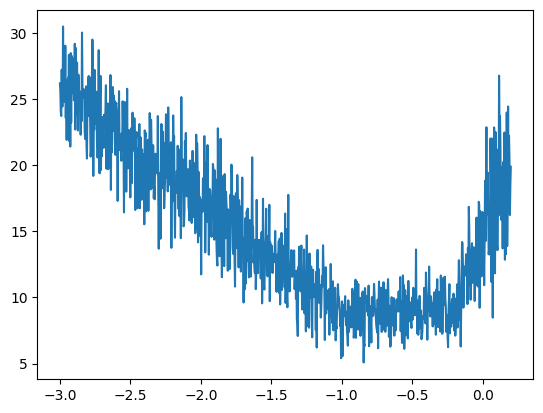

In [48]:
plt.plot(lr_exps, losses)